In [1]:
# Mount to my Google Drive
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/MyDrive/Yale Academic Course Work/Semester Work/Spring 2022 Semester/S&DS 492/Sparse Regression")

Mounted at /content/drive


In [2]:
# Check what GPU we are using
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c0196230-4be0-f56a-4285-25d9633e269f)


In [3]:
import tensorflow as tf
import numpy as np
import pickle

In [4]:
# Import our code
from linear_regression_generalization import generate_sparse_dataset, train_linreg_network

# Model Setup

In [5]:
# Dimension of problem
d = 250

# Sparsity of problem 
# There are r nonzero coordinates of the beta vector, and they are the first five coordinates
r = 5
indices = range(5)

In [6]:
# Number of training points
N =  100

In [ ]:
# Generate our training dataset
train_data = generate_sparse_dataset(N, d, r, indices=indices, filename=f'training_data_sparse_regression_{N}.pk')

In [ ]:
# And our test dataset
num_test = 100
test_data = generate_sparse_dataset(num_test, d, r, indices=indices, filename='test_data_sparse_regression.pk')

In [7]:
# Initialization shape and scales for our NN
w0 = tf.ones([2*d, 1])
alphas = list(np.logspace(-3, 0, 20))

In [8]:
# Load in previous data
with open(f'training_data_sparse_regression_{N}.pk', 'rb') as f:
    train_data = pickle.load(f)

with open('test_data_sparse_regression.pk', 'rb') as f:
    test_data = pickle.load(f)

# Model Training

In [ ]:
# Now let's train the models
output = train_linreg_network((train_data[0], train_data[1]), (test_data[0], test_data[1]), w0, alphas=alphas, lr=3*10**(-4))

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 72ms/step - loss: 0.3276 - val_loss: 1.0807
Epoch 94/10000
2/2 [==============================] - 0s 55ms/step - loss: 0.3241 - val_loss: 1.0804
Epoch 95/10000
2/2 [==============================] - 0s 52ms/step - loss: 0.3204 - val_loss: 1.0803
Epoch 96/10000
2/2 [==============================] - 0s 46ms/step - loss: 0.3171 - val_loss: 1.0802
Epoch 97/10000
2/2 [==============================] - 0s 34ms/step - loss: 0.3138 - val_loss: 1.0800
Epoch 98/10000
2/2 [==============================] - 0s 46ms/step - loss: 0.3105 - val_loss: 1.0799
Epoch 99/10000
2/2 [==============================] - 0s 51ms/step - loss: 0.3072 - val_loss: 1.0798
Epoch 100/10000
2/2 [==============================] - 0s 32ms/step - loss: 0.3038 - val_loss: 1.0797
Epoch 101/10000
2/2 [==============================] - 0s 44ms/step - loss: 0.3008 - val_loss: 1.0796
Epoch 102/10000
2/2 [==============================] 

In [ ]:
# Save the output from training
with open(f'sparse_generalization_{N}.pk', 'wb') as f:
        pickle.dump(output, f)

# Visualizing Results

In [9]:
import matplotlib.pyplot as plt

In [11]:
# Import prior outputs
with open('sparse_generalization_50.pk', 'rb') as f:
    output50 = pickle.load(f)

with open('sparse_generalization_100.pk', 'rb') as f:
    output100 = pickle.load(f)

with open('sparse_generalization_200.pk', 'rb') as f:
    output200 = pickle.load(f)

In [12]:
# Boolean lists, True if gradient descent does converge within 10^4 iterations, False otherwise (no convergence)
converge50 = [i for i in range(len(output50[2])) if output50[2][i] < 9999]
converge100 = [i for i in range(len(output100[2])) if output100[2][i] < 9999]
converge200 = [i for i in range(len(output200[2])) if output200[2][i] < 9999]

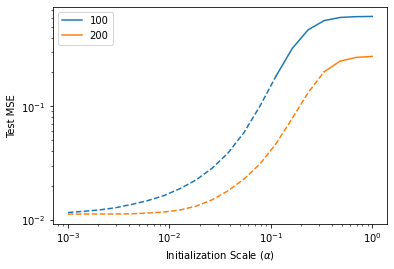

In [63]:
# Now plot the MSE on the test dataset against the initialization scale \alpha for each of the models we trained
fig = plt.figure(0)

MSE50 = [output50[1][i][-1] for i in range(len(alphas))]
MSE100 = [output100[1][i][-1] for i in range(len(alphas))]
MSE200 = [output200[1][i][-1] for i in range(len(alphas))]

# plt.plot(alphas[0:min(converge50)], MSE50[0:min(converge50)], color="#2ca02c", linestyle="dashed")
# plt.plot(alphas[(min(converge50)-1):], MSE100[(min(converge50)-1):], color="#2ca02c", label="50")

plt.plot(alphas[0:min(converge100)], MSE100[0:min(converge100)], color="#1f77b4", linestyle="dashed")
plt.plot(alphas[(min(converge100)-1):], MSE100[(min(converge100)-1):], color="#1f77b4", label="100")

plt.plot(alphas[0:min(converge200)], MSE200[0:min(converge200)], color="#ff7f0e", linestyle="dashed")
plt.plot(alphas[(min(converge200)-1):], MSE200[(min(converge200)-1):], color="#ff7f0e",label="200")

plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.xlabel(r"Initialization Scale ($\alpha$)")
plt.ylabel("Test MSE")

fig.show()
fig.savefig('visualize_test_MSE_log.png', dpi=300)

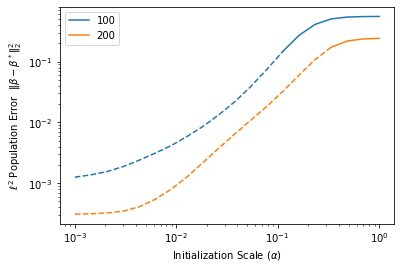

In [89]:
# Rather than looking at the MSE of the model on the test dataset, we can instead consider the \ell^2 distance between the learned and true 
# beta vector, as Woodworth and colleagues do in their paper. This is because, by the Riesz Representation Theorem, the model evaluated at any input x
# is completely detemined by \beta according to the \ell^2 inner product of \beta and x.  
fig = plt.figure(0)

beta_0 = train_data[2]

l2error50 = [np.linalg.norm((np.square(output50[3][i].numpy())[0:d] - np.square(output50[3][i].numpy())[d:]) - beta_0, ord=2)**2 for i in range(len(alphas))]
l2error100 = [np.linalg.norm((np.square(output100[3][i].numpy())[0:d] - np.square(output100[3][i].numpy())[d:]) - beta_0, ord=2)**2 for i in range(len(alphas))]
l2error200 = [np.linalg.norm((np.square(output200[3][i].numpy())[0:d] - np.square(output200[3][i].numpy())[d:]) - beta_0, ord=2)**2 for i in range(len(alphas))]

# plt.plot(alphas[0:min(converge50)], l2error50[0:min(converge50)], color="#2ca02c", linestyle="dashed")
# plt.plot(alphas[(min(converge50)-1):], l2error50[(min(converge50)-1):], color="#2ca02c", label="50")

plt.plot(alphas[0:min(converge100)], l2error100[0:min(converge100)], color="#1f77b4", linestyle="dashed")
plt.plot(alphas[(min(converge100)-1):], l2error100[(min(converge100)-1):], color="#1f77b4", label="100")

plt.plot(alphas[0:min(converge200)], l2error200[0:min(converge200)], color="#ff7f0e", linestyle="dashed")
plt.plot(alphas[(min(converge200)-1):], l2error200[(min(converge200)-1):], color="#ff7f0e",label="200")

plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.xlabel(r"Initialization Scale ($\alpha$)")
plt.ylabel(r"$\ell^2$ Population Error  $\Vert \beta - \beta^* \Vert_2^2$")

fig.show()
fig.savefig('12_population_error_log.png', dpi=300)

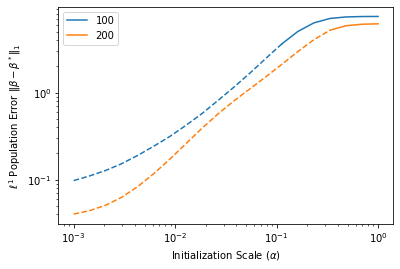

In [90]:
# Likewise, we look at the \ell^1 distance between the learned and true beta vector as a measure of the population error

l1error50 = [np.linalg.norm((tf.math.square(i)[0:d] - tf.math.square(i)[d:]) - beta_0, ord=1) for i in output50[3]]
l1error100 = [np.linalg.norm((tf.math.square(i)[0:d] - tf.math.square(i)[d:]) - beta_0, ord=1) for i in output100[3]]
l1error200 = [np.linalg.norm((tf.math.square(i)[0:d] - tf.math.square(i)[d:]) - beta_0, ord=1) for i in output200[3]]

fig = plt.figure(1)

# plt.plot(alphas[0:min(converge50)], l1error50[0:min(converge50)], color="#2ca02c", linestyle="dashed")
# plt.plot(alphas[(min(converge50)-1):], l1error50[(min(converge50)-1):], color="#2ca02c", label="50")
plt.plot(alphas[0:min(converge100)], l1error100[0:min(converge100)], color="#1f77b4", linestyle="dashed")
plt.plot(alphas[(min(converge100)-1):], l1error100[(min(converge100)-1):], color="#1f77b4", label="100")
plt.plot(alphas[0:min(converge200)], l1error200[0:min(converge200)], color="#ff7f0e", linestyle="dashed")
plt.plot(alphas[(min(converge200)-1):], l1error200[(min(converge200)-1):], color="#ff7f0e",label="200")


plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.xlabel(r"Initialization Scale ($\alpha$)")
plt.ylabel(r"$\ell^1$ Population Error $\Vert \beta - \beta^* \Vert_1$")
plt.show()
fig.savefig('11_population_error_log.png', dpi=300)

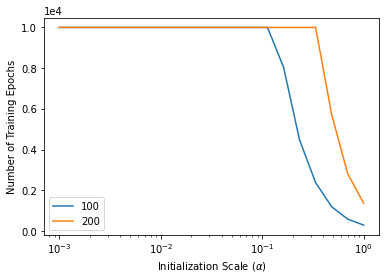

In [68]:
# Plot the number of iterations necessary for gradient descent to converge below 10^(-4),
# our predetmined threshold on the training loss
fig = plt.figure(2)

# plt.plot(alphas, output50[2], color="#2ca02c", label="50")

plt.plot(alphas, output100[2], color="#1f77b4", label="100")

plt.plot(alphas, output200[2], color="#ff7f0e", label="200")

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xscale("log")
plt.legend()

plt.xlabel(r"Initialization Scale ($\alpha$)")
plt.ylabel("Number of Training Epochs")

fig.show()
fig.savefig('interations_to_convergence.png', dpi=300)

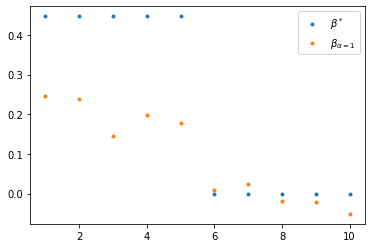

In [88]:
# Plot the first 10 components of the empirical solution vector \beta against the \ell_1 minimum solution vector
fig = plt.figure(3)

plt.plot(np.arange(1, 11), beta_0[0:10], '.', label=r"$\beta^*$")
plt.plot(np.arange(1, 11), (tf.math.square(output100[3][-1])[0:d] - tf.math.square(output100[3][-1])[d:])[0:10], '.', label=r"$\beta_{\alpha = 1}$")

plt.legend()
fig.savefig('visualize_solution_vec_1.png', dpi=300)